----

# The Optimist: Towards Fully Automated Graph Theory

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RandyRDavila/The-Optimist/blob/main/notebooks/experiment.ipynb)

This notebook walks you through automated conjecturing in graph theory by interacting with the *Optimist* agent. To begin, we first define several Python classes which represent the conjectures that the *Optimist* works with. 

----

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import pulp

from fractions import Fraction
from itertools import combinations


class Hypothesis:
    """
    A base class for graph hypotheses.

    Attributes:
    - statement (str): The hypothesis statement, which describes a property or condition on a graph.
    - true_object_set (set, optional): A set of objects (graphs) that satisfy the hypothesis.

    Methods:
    - __str__(): Returns the hypothesis statement as a string.
    - __repr__(): Returns the hypothesis statement in a formal representation.
    - __call__(name, df): Evaluates the hypothesis on a specific graph object, using its name and a DataFrame of graph data.
    - _le__(other): Compares the size of `true_object_set` with another Hypothesis instance.
    - __lt__(other): Checks if the `true_object_set` is smaller than that of another Hypothesis.
    - __ge__(other): Checks if the `true_object_set` is larger or equal in size to that of another Hypothesis.
    - __gt__(other): Checks if the `true_object_set` is larger than that of another Hypothesis.
    - __eq__(other): Checks if two Hypothesis instances have the same statement.
    - __hash__(): Returns a hash of the hypothesis based on the statement.
    """
    def __init__(self, statement, true_object_set=None):
        self.statement = statement
        self.true_object_set = true_object_set

    def __str__(self):
        return f"{self.statement}"

    def __repr__(self):
        return f"{self.statement}"

    def __call__(self, name, df):
        return df.loc[df["name"] == f"{name}.txt"][self.statement]

    def _le__(self, other):
        return len(self.true_object_set) <= len(other.true_object_set)

    def __lt__(self, other):
        return len(self.true_object_set) < len(other.true_object_set)

    def __ge__(self, other):
        return len(self.true_object_set) >= len(other.true_object_set)

    def __gt__(self, other):
        return len(self.true_object_set) > len(other.true_object_set)

    def __eq__(self, other):
        return self.__str__() == other.__str__()

    def __hash__(self):
        return hash((self.statement))

class Conclusion:
    """
    A base class for graph conclusions.

    Attributes:
    - lhs (str): The left-hand side of the inequality.
    - inequality (str): The inequality operator (e.g., '<=', '>=', '=').
    - rhs (str): The right-hand side of the inequality.
    - intercept (float): An optional intercept for linear expressions.

    Methods:
    - __str__(): Returns a string representation of the conclusion.
    - __repr__(): Returns a formal representation of the conclusion.
    - __call__(name, df): Evaluates the conclusion on a specific graph object, using its name and a DataFrame.
    - __hash__(): Returns a hash of the conclusion based on the string representation.
    """
    def __init__(self, lhs, inequality, rhs, intercept=0):
        self.lhs = lhs
        self.inequality = inequality
        self.rhs = rhs
        self.intercept = intercept

    def __str__(self):
        raise NotImplementedError("Subclasses must implement __str__")

    def __repr__(self):
        raise NotImplementedError("Subclasses must implement __repr__")

    def __call__(self, name, df):
        raise NotImplementedError("Subclasses must implement __call__")

    def __hash__(self):
        return hash((str(self)))

class Conjecture:
    """
    A base class for graph conjectures.

    Attributes:
    - hypothesis (Hypothesis): The hypothesis component of the conjecture.
    - conclusion (Conclusion): The conclusion component of the conjecture.
    - symbol (str): A symbol representing the object being conjectured (default is "G").
    - touch (int): The number of graphs that satisfy the hypothesis and conclusion.
    - sharps (set): A set of graphs that sharply satisfy the conjecture.
    - difficulty (int): The difficulty level associated with the conjecture.

    Methods:
    - __str__(): Returns a string representation of the conjecture.
    - __repr__(): Returns a formal representation of the conjecture.
    - __call__(name, df): Evaluates the conjecture on a specific graph object, using its name and a DataFrame.
    - get_sharp_graphs(df): Abstract method to retrieve sharp graphs from the DataFrame.
    - __eq__(other): Checks if two Conjecture instances have the same hypothesis and conclusion.
    - __hash__(): Returns a hash of the conjecture based on the string representation.
    """
    def __init__(self, hypothesis, conclusion, symbol="G", touch=0, sharps=None, difficulty=0):
        self.hypothesis = hypothesis
        self.conclusion = conclusion
        self.symbol = symbol
        self.touch = touch
        self.difficulty = difficulty

        self.sharps = set(sharps)

    def __str__(self):
        hypothesis = f"If {self.symbol} is {self.hypothesis}"
        return f"{hypothesis}, then {self.conclusion}"

    def __repr__(self):
        hypothesis = f"If {self.symbol} is {self.hypothesis}"
        return f"{hypothesis}, then {self.conclusion}"

    def __call__(self, name, df):
        if self.hypothesis(name, df).values[0]:
            return self.conclusion(name, df)
        else:
            return False

    def get_sharp_graphs(self, df):
        raise NotImplementedError("Subclasses must implement get_sharp_graphs")

    def __eq__(self, other):
        return self.__str__() == other.__str__()


    def __hash__(self):
        return hash((str(self)))


class MultiLinearConclusion(Conclusion):
    """
    A class for multilinear graph conclusions.

    Attributes:
    - lhs (str): The left-hand side of the inequality.
    - inequality (str): The inequality operator.
    - slopes (list): A list of slope coefficients for the multilinear expression.
    - rhs (list): A list of variables or invariants on the right-hand side of the inequality.
    - intercept (float): An optional intercept term.

    Methods:
    - __str__(): Returns a string representation of the multilinear conclusion.
    - __repr__(): Returns a formal representation of the conclusion.
    - __call__(name, df): Evaluates the conclusion on a specific graph object.
    - reversal(): Returns a new MultiLinearConclusion with the opposite inequality.
    - rhs_evaluate(x): Evaluates the right-hand side expression given an input `x`.
    - __hash__(): Returns a hash based on the string representation of the conclusion.
    - __eq__(other): Checks if two conclusions are equivalent.
    """
    def __init__(self, lhs, inequality, slopes, rhs, intercept):
        super().__init__(lhs, inequality, rhs, intercept)
        self.slopes = slopes

    def __str__(self):
        slope_terms = []
        for m, rhs in zip(self.slopes, self.rhs):
            if m == 1:
                slope_terms.append(f"{rhs}")
            elif m == -1:
                slope_terms.append(f"- {rhs}")
            elif m != 0:
                slope_terms.append(f"{m} * {rhs}")

        slope_str = " + ".join(slope_terms)

        if self.intercept > 0:
            result = f"{slope_str} + {self.intercept}"
        elif self.intercept < 0:
            result = f"{slope_str} - {abs(self.intercept)}"
        else:
            result = slope_str

        result = result.replace("+ -", "-").strip()
        return f"{self.lhs} {self.inequality} {result}"

    def __repr__(self):
        return self.__str__()

    def __call__(self, name, df):
        data = df.loc[df["name"] == f"{name}"]
        rhs_value = sum(m * data[r].values[0] for m, r in zip(self.slopes, self.rhs)) + self.intercept
        if self.inequality == "<=":
            return data[self.lhs].values[0] <= rhs_value
        elif self.inequality == ">=":
            return data[self.lhs].values[0] >= rhs_value
        else:
            data[self.lhs].values[0] == rhs_value

    def __eq__(self, other):
        return self.__str__() == other.__str__()

    def reversal(self):
        if self.inequality == "<=":
            return MultiLinearConclusion(self.lhs, ">=", self.slopes, self.rhs, self.intercept)
        elif self.inequality == ">=":
            return MultiLinearConclusion(self.lhs, "<=", self.slopes, self.rhs, self.intercept)

    def rhs_evaluate(self, x):
        return sum(m * x for m in self.slopes) + self.intercept

    def __hash__(self):
        return hash((str(self)))


class MultiLinearConjecture(Conjecture):
    """
    A class for multilinear graph conjectures.

    Attributes:
    - hypothesis (Hypothesis): The hypothesis component of the conjecture.
    - conclusion (MultiLinearConclusion): The conclusion component of the conjecture.
    - symbol (str): A symbol representing the object being conjectured.
    - touch (int): The number of graphs that satisfy the hypothesis and conclusion.
    - sharps (set): A set of graphs that sharply satisfy the conjecture.
    - difficulty (int): The difficulty level associated with the conjecture.

    Methods:
    - __repr__(): Returns a formal representation of the multilinear conjecture.
    - get_sharp_graphs(df): Retrieves graphs from the DataFrame that sharply satisfy the conjecture.
    - false_graphs(df): Retrieves graphs from the DataFrame that fail to satisfy the conjecture.
    - is_equal(): Checks if the inequality in the conclusion is equality.
    - get_functions(invariant_dict): Returns functions to compute LHS and RHS of the conjecture for a graph.
    - get_penality_function(penality_dict): Returns a function to compute penalties based on the conjecture.
    - plot(df): Plots the conjecture data if the conclusion is linear.
    - __hash__(): Returns a hash based on the string representation of the conjecture.
    - __eq__(other): Checks if two conjectures have the same hypothesis and conclusion.
    """
    def __repr__(self):
        hypothesis = f"If {self.symbol} is {self.hypothesis}"
        return f"{hypothesis}, then {self.conclusion}."

    def get_sharp_graphs(self, df):
        return df.loc[(df[self.hypothesis.statement] == True) &
                      (df[self.conclusion.lhs] == sum(self.conclusion.slopes[i] * df[self.conclusion.rhs[i]]
                                                      for i in range(len(self.conclusion.rhs))) + self.conclusion.intercept)]

    def __eq__(self, other):
        return self.hypothesis == other.hypothesis and self.conclusion == other.conclusion

    def false_graphs(self, df):
        if self.conclusion.inequality == "<=":
            return df.loc[(df[self.hypothesis.statement] == True) &
                          (df[self.conclusion.lhs] > sum(self.conclusion.slopes[i] * df[self.conclusion.rhs[i]]
                                                         for i in range(len(self.conclusion.rhs))) + self.conclusion.intercept)]
        elif self.conclusion.inequality == ">=":
            return df.loc[(df[self.hypothesis.statement] == True) &
                          (df[self.conclusion.lhs] < sum(self.conclusion.slopes[i] * df[self.conclusion.rhs[i]]
                                                         for i in range(len(self.conclusion.rhs))) + self.conclusion.intercept)]
        else:
            return df.loc[(df[self.hypothesis.statement] == True) &
                          (df[self.conclusion.lhs] != sum(self.conclusion.slopes[i] * df[self.conclusion.rhs[i]]
                                                         for i in range(len(self.conclusion.rhs))) + self.conclusion.intercept)]
    def is_equal(self):
        return self.conclusion.inequality == "="

    def get_functions(self, invariant_dict):
        """
        Returns a tuple of functions (target_function, rhs_function) that compute the LHS and RHS
        of the conjecture for a given networkx graph.

        Parameters:
        - invariant_dict: A dictionary where the keys are the string names of the invariants
                          and the values are the corresponding functions that compute them.

        Returns:
        - A tuple (target_function, rhs_function)
        """

        # Define the target_function to compute the LHS invariant
        def target_function(graph):
            if self.conclusion.lhs in invariant_dict:
                return invariant_dict[self.conclusion.lhs](graph)
            else:
                raise ValueError(f"LHS invariant '{self.conclusion.lhs}' not found in the dictionary.")

        # Define the rhs_function to compute the RHS expression
        def rhs_function(graph):
            rhs_value = 0
            for slope, rhs_invariant in zip(self.conclusion.slopes, self.conclusion.rhs):
                if rhs_invariant in invariant_dict:
                    rhs_value += slope * invariant_dict[rhs_invariant](graph)
                else:
                    raise ValueError(f"RHS invariant '{rhs_invariant}' not found in the dictionary.")
            return rhs_value + self.conclusion.intercept

        def hypothesis_function(graph):
            if self.hypothesis in invariant_dict:
                return invariant_dict[self.hypothesis](graph)
            else:
                raise ValueError(f"Hypothesis invariant '{self.hypothesis}' not found in the dictionary.")

        return hypothesis_function, target_function, rhs_function

    def get_penality_function(self, penality_dict):
        """
        Returns a function that computes the penalty for a given networkx graph.
        """
        def penality_function(graph):
            hyp = str(self.hypothesis)
            if hyp in penality_dict:
                return penality_dict[hyp](graph)
            else:
                raise ValueError(f"Hypothesis '{hyp}' not found in the dictionary.")

        return penality_function

    def plot(self, df):
        import matplotlib.pyplot as plt
        import seaborn as sns
        sns.set_theme()

        if len(self.conclusion.slopes) == 1:
            # Filter dataframe where the hypothesis holds
            df = df[df[self.hypothesis.statement] == True]

            # Set up data for plotting
            y = df[self.conclusion.lhs]
            x = df[self.conclusion.rhs]
            rhs = self.conclusion.rhs_evaluate(x)

            # Create a figure and axis object
            fig, ax = plt.subplots(figsize=(10, 10))

            # Plot the data
            ax.set_title(f"{self.__repr__()}")
            ax.scatter(x, y, color='blue', label=f'Data')
            ax.plot(x, rhs, color='red', label=f'Prediction: {self.conclusion}')

            # Set labels and grid
            ax.set_xlabel(self.conclusion.rhs)
            ax.set_ylabel(self.conclusion.lhs)
            ax.grid(True)
            ax.legend()

            # Return the figure
            return fig
        else:
            print("Cannot plot multi-linear conjectures")
            return None

    def __hash__(self):
        return hash((str(self)))

    def __eq__(self, other):
        return self.__str__() == other.__str__()


---

# Inequality Generation

In the code cell below we write a function `make_linear_conjecture` which implements a mixed-integer linear program to find possible inequalities relating a target invariant to a collection of other invariants. Afterwards, we write the `make_all_linear_conjectures` function which generates upper and lower bound multilinear conjectures for every unique pair of invariants in 'others' combined with each property in 'properties'. 

---

In [2]:
def make_linear_conjectures(df, target, others, hyp="a connected graph", symbol="G",):
    """
    Generates upper and lower bound multilinear conjectures for a target variable
    using a mixed-integer programming approach to maximize the number of equalities at extreme values.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing graph data and associated variables (invariants).
    target : str
        The name of the target variable (dependent variable) in the conjecture.
    others : list of str
        A list of other variable names (independent variables or invariants) to be used in the conjecture.
    hyp : str, optional
        The name of the hypothesis variable, indicating the condition applied to graphs (default is "a connected graph").
    symbol : str, optional
        The symbol representing the object in the conjecture (default is "G").

    Returns
    -------
    tuple
        A tuple containing:
        - MultiLinearConjecture for the upper bound.
        - MultiLinearConjecture for the lower bound (if different slopes exist), else None.
    """
    pulp.LpSolverDefault.msg = 0

    # Filter data for the hypothesis condition.
    df = df[df[hyp] == True]
    true_objects = df["name"].tolist()

    # Preprocess the data to find the maximum Y for each X for the upper bound
    df_upper = df.loc[df.groupby(others)[target].idxmax()]
    # Preprocess the data to find the minimum Y for each X for the lower bound
    df_lower = df.loc[df.groupby(others)[target].idxmin()]

    # Extract the data for the upper and lower bound problems
    Xs_upper = [df_upper[other].tolist() for other in others]
    Y_upper = df_upper[target].tolist()
    Xs_lower = [df_lower[other].tolist() for other in others]
    Y_lower = df_lower[target].tolist()

    # Initialize the MIP problem.
    prob = pulp.LpProblem("Maximize_Equality", pulp.LpMaximize)

    # Initialize the variables for the MIP (one set for upper bound and one for lower bound).
    ws_upper = [pulp.LpVariable(f"w_upper{i+1}", upBound=4, lowBound=-4) for i in range(len(others))]  # Weights for upper bound
    ws_lower = [pulp.LpVariable(f"w_lower{i+1}", upBound=4, lowBound=-4) for i in range(len(others))]  # Weights for lower bound
    b_upper = pulp.LpVariable("b_upper", upBound=3, lowBound=-3)
    b_lower = pulp.LpVariable("b_lower", upBound=3, lowBound=-3)

    # Binary variables z_j^upper and z_j^lower to maximize equality conditions for extreme points
    z_upper = [pulp.LpVariable(f"z_upper{j}", cat="Binary") for j in range(len(Y_upper))]
    z_lower = [pulp.LpVariable(f"z_lower{j}", cat="Binary") for j in range(len(Y_lower))]

    M = 1000  # Big-M value

    # Upper bound constraints (maximize equality on max Y values)
    for j in range(len(Y_upper)):
        prob += pulp.lpSum([ws_upper[i] * Xs_upper[i][j] for i in range(len(others))]) + b_upper >= Y_upper[j]
        prob += pulp.lpSum([ws_upper[i] * Xs_upper[i][j] for i in range(len(others))]) >= b_upper
        prob += pulp.lpSum([ws_upper[i] * Xs_upper[i][j] for i in range(len(others))]) + b_upper - Y_upper[j] <= M * (1 - z_upper[j])

    # Lower bound constraints (maximize equality on min Y values)
    for j in range(len(Y_lower)):
        prob += pulp.lpSum([ws_lower[i] * Xs_lower[i][j] for i in range(len(others))]) + b_lower <= Y_lower[j]
        prob += pulp.lpSum([ws_lower[i] * Xs_lower[i][j] for i in range(len(others))]) >= b_lower
        prob += Y_lower[j] - pulp.lpSum([ws_lower[i] * Xs_lower[i][j] for i in range(len(others))]) - b_lower <= M * (1 - z_lower[j])

    # Maximize the number of equalities for both upper and lower bounds
    prob += pulp.lpSum(z_upper) + pulp.lpSum(z_lower)

    # Solve the MIP
    prob.solve()

    if prob.status != 1:
        print("No feasible solution found.")
        return None
    else:
        weights_upper = [Fraction(w.varValue).limit_denominator(10) for w in ws_upper]
        weights_lower = [Fraction(w.varValue).limit_denominator(10) for w in ws_lower]
        b_upper_value = Fraction(b_upper.varValue).limit_denominator(10)
        b_lower_value = Fraction(b_lower.varValue).limit_denominator(10)

        if weights_lower == weights_upper and b_upper_value == b_lower_value:
            touch_upper = len(true_objects)

            # Create the hypothesis and conclusion objects for both upper and lower bounds.
            hypothesis = Hypothesis(hyp, true_object_set=true_objects)
            upper_conclusion = MultiLinearConclusion(target, "=", weights_upper, others, b_upper_value)

            # Return the full conjecture object (not the conclusion directly).
            return MultiLinearConjecture(hypothesis, upper_conclusion, symbol, touch_upper, true_objects), None
        else:
            Xs_true_upper = [df[other].tolist() for other in others]
            Y_true_upper = df[target].tolist()
            Xs_true_lower = [df[other].tolist() for other in others]
            Y_true_lower = df[target].tolist()
            # Compute the number of instances of equality - the touch number of the conjecture.
            touch_set_upper = set([true_objects[j] for j in range(len(Y_true_upper)) if
                                Y_true_upper[j] == sum(weights_upper[i] * Xs_true_upper[i][j] for i in range(len(others))) + b_upper_value])
            touch_set_lower = set([true_objects[j] for j in range(len(Y_true_lower)) if Y_true_lower[j] == sum(weights_lower[i] * Xs_true_lower[i][j] for i in range(len(others))) + b_lower_value])

            touch_upper = len(touch_set_upper)
            touch_lower = len(touch_set_lower)

            # Create the hypothesis and conclusion objects for both upper and lower bounds.
            hypothesis = Hypothesis(hyp, true_object_set=true_objects)
            upper_conclusion = MultiLinearConclusion(target, "<=", weights_upper, others, b_upper_value)
            lower_conclusion = MultiLinearConclusion(target, ">=", weights_lower, others, b_lower_value)

            # Return the full conjecture object (not the conclusion directly).
            return MultiLinearConjecture(hypothesis, upper_conclusion, symbol, touch_upper, touch_set_upper), \
                MultiLinearConjecture(hypothesis, lower_conclusion, symbol, touch_lower, touch_set_lower)

def make_all_linear_conjectures(df, target, others, properties):
    """
    Generates upper and lower bound multilinear conjectures for every unique pair of invariants in 'others'
    combined with each property in 'properties'. Calls `make_linear_conjectures` for each combination.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing graph data and associated variables (invariants).
    target : str
        The name of the target variable in the conjecture.
    others : list of str
        A list of other variable names (independent variables or invariants).
    properties : list of str
        A list of properties (hypotheses) to apply for conjecture generation.

    Returns
    -------
    tuple
        A tuple containing:
        - A list of upper bound MultiLinearConjecture objects for each valid pair of variables and property.
        - A list of lower bound MultiLinearConjecture objects (if they exist) for each valid pair of variables and property.
    """
    upper_conjectures = []
    lower_conjectures = []
    seen_pairs = []
    for other1, other2 in combinations(others, 2):
        set_pair = set([other1, other2])
        if set_pair not in seen_pairs:
            seen_pairs.append(set_pair)
            for prop in properties:
                # Ensure that neither of the 'other' invariants equals the target.
                if other1 != target and other2 != target:
                    # Generate the conjecture for this combination of two invariants.
                    upper_conj, lower_conj = make_linear_conjectures(df, target, [other1, other2], hyp=prop)
                    upper_conjectures.append(upper_conj)
                    if lower_conj:
                        lower_conjectures.append(lower_conj)

    return upper_conjectures, lower_conjectures


---

# Heuristics

The following heuristics filter, prioritize, and refine a set of conjectures based on factors such as redundancy, generality, equality conditions, and data consistency. These heuristics are useful for identifying the most relevant conjectures and removing those that are less impactful or redundant.

1. **Hazel Heuristic**:
 - Removes duplicate conjectures and conjectures that do not attain equality.
 - Sorts the remaining conjectures by the number of instances where equality holds (touch number), returning a prioritized list.
 
2. **Morgan Heuristic**:
 - Removes conjectures that are redundant due to a more general conjecture with the same conclusion but a broader hypothesis.
 - Retains the most general version of each conjecture.

3. **Weak Smokey**:
 - Selects conjectures that either satisfy equality or contribute new instances of sharp graphs (where the conjecture holds as equality).
 - Aims to collect conjectures that cover distinct instances where equality holds without being overly strict.

4. **Strong Smokey**:
 - Similar to Weak Smokey, but more stringent, only including conjectures whose set of sharp graphs is a superset of those in the current strong conjectures list.
 - Focuses on conjectures that strongly subsume others in terms of sharp graphs.

5. **Filter False Conjectures**:
 - Removes conjectures that have counterexamples (i.e., graphs in the DataFrame that do not satisfy the conjecture).
 - Ensures only consistent conjectures are retained in the final list.


---

In [3]:
def hazel_heuristic(conjectures, min_touch=0):
    """
    Filters and sorts a list of conjectures based on touch number.

    This heuristic:
    - Removes duplicate conjectures.
    - Removes conjectures that never attain equality (touch <= min_touch).
    - Sorts the remaining conjectures in descending order of touch number.

    Parameters
    ----------
    conjectures : list of Conjecture
        The list of conjectures to filter and sort.
    min_touch : int, optional
        The minimum touch number required for a conjecture to be retained (default is 0).

    Returns
    -------
    list of Conjecture
        The sorted list of conjectures with the highest touch numbers.
    """
    # Remove duplicate conjectures.
    conjectures = list(set(conjectures))

    # Remove conjectures never attaining equality.
    conjectures = [conj for conj in conjectures if conj.touch > min_touch]

    # Sort the conjectures by touch number.
    conjectures.sort(key=lambda x: x.touch, reverse=True)

    # Return the sorted list of conjectures.
    return conjectures


def morgan_heuristic(conjectures):
    """
    Removes redundant conjectures based on generality.

    A conjecture is considered redundant if another conjecture has the same conclusion
    and a more general hypothesis (i.e., its true_object_set is a superset of the redundant one).

    Parameters
    ----------
    conjectures : list of Conjecture
        The list of conjectures to filter.

    Returns
    -------
    list of Conjecture
        A list with redundant conjectures removed.
    """
    new_conjectures = conjectures.copy()

    for conj_one in conjectures:
        for conj_two in new_conjectures.copy():  # Make a copy for safe removal
            # Avoid comparing the conjecture with itself
            if conj_one != conj_two:
                # Check if conclusions are the same and conj_one's hypothesis is more general
                if conj_one.conclusion == conj_two.conclusion and conj_one.hypothesis > conj_two.hypothesis:
                    new_conjectures.remove(conj_two)  # Remove the less general conjecture (conj_two)

    return new_conjectures


def weak_smokey(conjectures):
    """
    Selects conjectures based on equality and distinct sharp graphs.

    This heuristic:
    - Starts with the conjecture having the highest touch number.
    - Retains conjectures that either satisfy equality or introduce new sharp graphs.

    Parameters
    ----------
    conjectures : list of Conjecture
        The list of conjectures to filter.

    Returns
    -------
    list of Conjecture
        A list of strong conjectures with distinct or new sharp graphs.
    """
    # Start with the conjecture that has the highest touch number (first in the list).
    conj = conjectures[0]

    # Initialize the list of strong conjectures with the first conjecture.
    strong_conjectures = [conj]

    # Get the set of sharp graphs (i.e., graphs where the conjecture holds as equality) for the first conjecture.
    sharp_graphs = conj.sharps

    # Iterate over the remaining conjectures in the list.
    for conj in conjectures[1:]:
        if conj.is_equal():
            strong_conjectures.append(conj)
            sharp_graphs = sharp_graphs.union(conj.sharps)
        else:
            # Check if the current conjecture shares the same sharp graphs as any already selected strong conjecture.
            if any(conj.sharps.issuperset(known.sharps) for known in strong_conjectures):
                # If it does, add the current conjecture to the list of strong conjectures.
                strong_conjectures.append(conj)
                # Update the set of sharp graphs to include the newly discovered sharp graphs.
                sharp_graphs = sharp_graphs.union(conj.sharps)
            # Otherwise, check if the current conjecture introduces new sharp graphs (graphs where the conjecture holds).
            elif conj.sharps - sharp_graphs != set():
                # If new sharp graphs are found, add the conjecture to the list.
                strong_conjectures.append(conj)
                # Update the set of sharp graphs to include the newly discovered sharp graphs.
                sharp_graphs = sharp_graphs.union(conj.sharps)

    # Return the list of strong, non-redundant conjectures.
    return strong_conjectures


def strong_smokey(conjectures):
    """
    Selects conjectures that strongly subsume others based on sharp graphs.

    This heuristic:
    - Starts with the conjecture having the highest touch number.
    - Retains conjectures whose sharp graphs are supersets of previously selected conjectures.

    Parameters
    ----------
    conjectures : list of Conjecture
        The list of conjectures to filter.

    Returns
    -------
    list of Conjecture
        A list of conjectures with non-redundant, strongly subsuming sharp graphs.
    """
    # Start with the conjecture that has the highest touch number (first in the list).
    conj = conjectures[0]

    # Initialize the list of strong conjectures with the first conjecture.
    strong_conjectures = [conj]

    # Get the set of sharp graphs (i.e., graphs where the conjecture holds as equality) for the first conjecture.
    sharp_graphs = conj.sharps

    # Iterate over the remaining conjectures in the list.
    for conj in conjectures[1:]:
        if conj.is_equal():
            strong_conjectures.append(conj)
        else:
            # Check if the current conjecture set of sharp graphs is a superset of any already selected strong conjecture.
            if any(conj.sharps.issuperset(known.sharps) for known in strong_conjectures):
                # If it does, add the current conjecture to the list of strong conjectures.
                strong_conjectures.append(conj)
                sharp_graphs = sharp_graphs.union(conj.sharps)

    # Return the list of strong, non-redundant conjectures.
    return strong_conjectures


def filter_false_conjectures(conjectures, df):
    """
    Filters conjectures to remove those with counterexamples in the provided data.

    Parameters
    ----------
    conjectures : list of Conjecture
        The list of conjectures to filter.
    df : pandas.DataFrame
        The DataFrame containing graph data.

    Returns
    -------
    list of Conjecture
        A list of conjectures with no counterexamples in the DataFrame.
    """
    new_conjectures = []
    for conj in conjectures:
        if conj.false_graphs(df).empty:
            new_conjectures.append(conj)
    return new_conjectures


---

# The *Optimist* Agent

The `Optimist` class is designed to generate and manage conjectures about graph invariants based on a given set of graphs and their computed invariants. It uses a combination of heuristics and methods to formulate conjectures, filter out known theorems, and update its knowledge base with new information. The agent aims to discover new relationships (conjectures) between graph invariants by analyzing the data and applying mathematical heuristics.


---

In [4]:
class Optimist:
    """
    An agent that generates, refines, and stores mathematical conjectures on graph properties.

    Attributes
    ----------
    graphs : list
        A list of initial graphs used for conjecture generation.
    invariants : dict
        A dictionary where keys are invariant names and values are functions that compute the invariant for a graph.
    known_theorems : list, optional
        A list of known theorems to filter redundant conjectures.

    Methods
    -------
    build_knowledge()
        Computes invariant values for each graph and stores them in a DataFrame.
    conjecture(target, use_strong_smokey=False)
        Generates conjectures for a target invariant using heuristics, filtering known theorems, and storing results.
    write_on_the_wall(target)
        Displays stored conjectures for a given target along with details on equality instances.
    update_graph_knowledge(graph)
        Adds a new graph to the knowledge base and updates the stored invariant values.
    update_known_theorems(theorems)
        Adds a list of theorems to the known theorems list to avoid redundant conjectures.
    filter_known_upper_bounds(target, index)
        Filters a specific upper bound by adding it to known theorems and re-generating conjectures.
    filter_known_lower_bounds(target, index)
        Filters a specific lower bound by adding it to known theorems and re-generating conjectures.
    """

    def __init__(self, graphs: list, invariants: dict, known_theorems=[]):
        """
        Initializes the Optimist agent.

        Parameters
        ----------
        graphs : list
            A list of initial graphs to start with.
        invariants : dict
            A dictionary where keys are function names and values are the functions themselves.
        known_theorems : list, optional
            A list of known theorems to filter out redundant conjectures.
        """
        self.graphs = graphs
        self.invariants = invariants
        self.upper_conjectures = {}
        self.lower_conjectures = {}
        self.all_conjectures = {}
        self.known_theorems = known_theorems

    def build_knowledge(self):
        """
        Computes invariant values for each graph and stores them in a DataFrame.

        Iterates over the list of graphs, applies invariant functions to each graph,
        and stores the results in a DataFrame for conjecture generation.
        """
        rows = []
        for i, G in enumerate(self.graphs):
            row = {"name": f"G{i}"}
            for name, function in self.invariants.items():
                row[name] = function(G)
            rows.append(row)
        self.df = pd.DataFrame(rows)

    def conjecture(self, target, use_strong_smokey=False):
        """
        Generates and filters conjectures for a target invariant.

        Uses upper and lower bound heuristics to create conjectures for the target invariant.
        Applies filtering heuristics to remove false, redundant, and less significant conjectures.

        Parameters
        ----------
        target : str
            The target variable for conjecture generation.
        use_strong_smokey : bool, optional
            Whether to use the strong version of the Smokey heuristic (default is False).

        Returns
        -------
        tuple
            A tuple containing lists of upper and lower bound conjectures.
        """
        numerical_columns = self.df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        boolean_columns = self.df.select_dtypes(include=['bool']).columns.tolist()
        upper_conjectures, lower_conjectures = make_all_linear_conjectures(self.df, target, numerical_columns, boolean_columns)
        upper_conjectures = filter_false_conjectures(upper_conjectures, self.df)
        lower_conjectures = filter_false_conjectures(lower_conjectures, self.df)
        upper_conjectures, lower_conjectures = hazel_heuristic(upper_conjectures, min_touch=1), hazel_heuristic(lower_conjectures, min_touch=1)
        upper_conjectures, lower_conjectures = morgan_heuristic(upper_conjectures), morgan_heuristic(lower_conjectures)
        if use_strong_smokey:
            upper_conjectures, lower_conjectures = strong_smokey(upper_conjectures), strong_smokey(lower_conjectures)
        else:
            upper_conjectures, lower_conjectures = weak_smokey(upper_conjectures), weak_smokey(lower_conjectures)
        self.upper_conjectures[target] = [conj for conj in upper_conjectures if conj not in self.known_theorems]
        self.lower_conjectures[target] = [conj for conj in lower_conjectures if conj not in self.known_theorems]
        self.all_conjectures[target] = upper_conjectures + lower_conjectures
        return upper_conjectures, lower_conjectures

    def write_on_the_wall(self, target):
        """
        Displays stored conjectures for a given target.

        Prints each conjecture along with details about the number of graphs
        where equality holds (touch number).

        Parameters
        ----------
        target : str
            The target variable whose conjectures are to be displayed.
        """
        if target not in self.upper_conjectures or target not in self.lower_conjectures:
            self.conjecture(target)
        for i, upper_conj in enumerate(self.upper_conjectures[target]):
            print(f"Conjecture {i}. {upper_conj}")
            print(f"With equality on {upper_conj.touch} graphs.\n")

        print()
        for i, lower_conj in enumerate(self.lower_conjectures[target]):
            print(f"Conjecture {i}. {lower_conj}")
            print(f"With equality on {lower_conj.touch} graphs.\n")

    def update_graph_knowledge(self, graph):
        """
        Adds a new graph to the agent's knowledge base and updates the DataFrame.

        Computes invariant values for the new graph and appends them to the DataFrame.

        Parameters
        ----------
        graph : networkx.Graph
            The new graph to be added.
        """
        self.graphs.append(graph)
        new_row = {"name": f"G{len(self.graphs)}"}
        for name, function in self.invariants.items():
            new_row[name] = function(graph)
        self.df = pd.concat([self.df, pd.DataFrame([new_row])], ignore_index=True)

    def update_known_theorems(self, theorems):
        """
        Adds new theorems to the list of known theorems to filter redundant conjectures.

        Parameters
        ----------
        theorems : list
            A list of theorems to add to the known theorems list.
        """
        for thm in theorems:
            self.known_theorems.append(thm)

    def filter_known_upper_bounds(self, target, index):
        """
        Filters a specific upper bound by adding it to known theorems and re-generating conjectures.

        Parameters
        ----------
        target : str
            The target variable whose upper bounds are being filtered.
        index : int
            The index of the conjecture to add to known theorems.
        """
        theorem = self.upper_conjectures[target][index - 1]
        self.known_theorems.append(theorem)
        self.conjecture(target)

    def filter_known_lower_bounds(self, target, index):
        """
        Filters a specific lower bound by adding it to known theorems and re-generating conjectures.

        Parameters
        ----------
        target : str
            The target variable whose lower bounds are being filtered.
        index : int
            The index of the conjecture to add to known theorems.
        """
        theorem = self.lower_conjectures[target][index - 1]
        self.known_theorems.append(theorem)
        self.conjecture(target)


---

We next write a collection of functions to compute numerical invariants and boolean properties of graphs. 


---

In [5]:
# The neighborhood of a vertex v in G.
def neighborhood(G, v):
    """
    Returns the neighborhood of a vertex in a graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph in which the neighborhood is computed.
    v : node
        The vertex for which the neighborhood is computed.

    Returns
    -------
    list
        A list of neighbors of vertex v.
    """
    return [n for n in G.neighbors(v)]


# The closed neighborhood of a vertex v in G.
def closed_neighborhood(G, v):
    """
    Returns the closed neighborhood of a vertex in a graph, including the vertex itself.

    Parameters
    ----------
    G : networkx.Graph
        The graph in which the closed neighborhood is computed.
    v : node
        The vertex for which the closed neighborhood is computed.

    Returns
    -------
    list
        A list of neighbors of vertex v, including v itself.
    """
    return [n for n in G.neighbors(v)] + [v]


# The minimum vertex degree of the graph.
def minimum_degree(G):
    """
    Returns the minimum degree of vertices in the graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph for which the minimum degree is computed.

    Returns
    -------
    int
        The minimum degree among all vertices in the graph.
    """
    return min(G.degree(node) for node in G.nodes())


# The maximum vertex degree of the graph.
def maximum_degree(G):
    """
    Returns the maximum degree of vertices in the graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph for which the maximum degree is computed.

    Returns
    -------
    int
        The maximum degree among all vertices in the graph.
    """
    return max(G.degree(node) for node in G.nodes())


# The harmonic index of the graph.
def harmonic_index(G):
    """
    Computes the harmonic index of a graph, based on the degrees of each edge's endpoints.

    Parameters
    ----------
    G : networkx.Graph
        The graph for which the harmonic index is computed.

    Returns
    -------
    float
        The harmonic index of the graph.
    """
    return sum(2 / (G.degree(v) + G.degree(u)) for v, u in G.edges())


# The order of the graph - the number of vertices.
def n(G):
    """
    Returns the order of the graph (number of vertices).

    Parameters
    ----------
    G : networkx.Graph
        The graph whose order is computed.

    Returns
    -------
    int
        The number of vertices in the graph.
    """
    return G.number_of_nodes()


# Is the graph connected?
def connected_graph(G):
    """
    Determines if a graph is connected.

    Parameters
    ----------
    G : networkx.Graph
        The graph to check for connectivity.

    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """
    return nx.is_connected(G)


# Is the graph a tree?
def tree(G):
    """
    Determines if a graph is a tree.

    Parameters
    ----------
    G : networkx.Graph
        The graph to check if it is a tree.

    Returns
    -------
    bool
        True if the graph is a tree, False otherwise.
    """
    return nx.is_tree(G)


# Is the graph connected and regular?
def connected_and_regular_graph(G):
    """
    Determines if a graph is connected and regular (all vertices have the same degree).

    Parameters
    ----------
    G : networkx.Graph
        The graph to check for connectivity and regularity.

    Returns
    -------
    bool
        True if the graph is connected and regular, False otherwise.
    """
    return nx.is_connected(G) and minimum_degree(G) == maximum_degree(G)


# Is the graph connected and bipartite?
def connected_and_bipartite_graph(G):
    """
    Determines if a graph is connected and bipartite.

    Parameters
    ----------
    G : networkx.Graph
        The graph to check for connectivity and bipartiteness.

    Returns
    -------
    bool
        True if the graph is connected and bipartite, False otherwise.
    """
    return nx.is_connected(G) and nx.is_bipartite(G)


# The matching number of a graph.
def matching_number(G):
    """
    Computes the matching number of a graph, defined as the maximum number of edges
    that do not share an endpoint.

    Parameters
    ----------
    G : networkx.Graph
        The graph for which the matching number is computed.

    Returns
    -------
    int
        The matching number of the graph.
    """
    pulp.LpSolverDefault.msg = 0
    prob = pulp.LpProblem("MaximumMatchingSet", pulp.LpMaximize)
    variables = {edge: pulp.LpVariable(f"x{i + 1}", 0, 1, pulp.LpBinary) for i, edge in enumerate(G.edges())}

    # Set the maximum matching objective function
    prob += pulp.lpSum(variables)

    # Set constraints
    for node in G.nodes():
        incident_edges = [variables[edge] for edge in variables if node in edge]
        prob += sum(incident_edges) <= 1

    prob.solve()
    solution_set = {edge for edge in variables if variables[edge].value() == 1}
    return len(solution_set)


def domination_number(G):
    """
    Computes the domination number of a graph, defined as the minimum number of vertices
    needed to dominate all other vertices in the graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph for which the domination number is computed.

    Returns
    -------
    int
        The domination number of the graph.
    """
    pulp.LpSolverDefault.msg = 0
    prob = pulp.LpProblem("MinDominatingSet", pulp.LpMinimize)
    variables = {node: pulp.LpVariable(f"x{i + 1}", 0, 1, pulp.LpBinary) for i, node in enumerate(G.nodes())}

    # Set the domination number objective function
    prob += pulp.lpSum(variables)

    # Set constraints
    for node in G.nodes():
        combination = [variables[n] for n in variables if n in closed_neighborhood(G, node)]
        prob += pulp.lpSum(combination) >= 1

    prob.solve()
    solution_set = {node for node in variables if variables[node].value() == 1}
    return len(solution_set)


# The edge domination number of the graph.
def min_maximal_matching_number(G):
    """
    Computes the minimum maximal matching number of a graph, equivalent to the edge domination number.

    Parameters
    ----------
    G : networkx.Graph
        The graph for which the minimum maximal matching number is computed.

    Returns
    -------
    int
        The minimum maximal matching number of the graph.
    """
    G = nx.line_graph(G)
    return domination_number(G)


# The independence number of the graph.
def independence_number(G):
    """
    Computes the independence number of a graph, defined as the maximum number of pairwise
    nonadjacent vertices.

    Parameters
    ----------
    G : networkx.Graph
        The graph for which the independence number is computed.

    Returns
    -------
    int
        The independence number of the graph.
    """
    pulp.LpSolverDefault.msg = 0
    prob = pulp.LpProblem("MaximumIndependentSet", pulp.LpMaximize)
    variables = {node: pulp.LpVariable(f"x{i + 1}", 0, 1, pulp.LpBinary) for i, node in enumerate(G.nodes())}

    # Set the independence number objective function
    prob += pulp.lpSum(variables)

    # Set constraints for independence
    for e in G.edges():
        prob += variables[e[0]] + variables[e[1]] <= 1

    prob.solve()
    solution_set = {node for node in variables if variables[node].value() == 1}
    return len(solution_set)




---

Once a collection of functions has been written we may now initialize the *Optimist* agent with a small collection of graphs, and invariants. 

---

In [6]:
graphs = [nx.complete_graph(2), nx.complete_graph(3), nx.path_graph(3)]

invariants = {
        "a connected graph": connected_graph,
        "a connected and bipartite graph": connected_and_bipartite_graph,
        "a connected and regular graph": connected_and_regular_graph,
        "a tree": tree,
        "independence_number": independence_number,
        "order": n,
        "min_maximal_matching_number": min_maximal_matching_number,
        "domination_number": domination_number,
        "harmonic_index": harmonic_index,
        "matching_number": matching_number,
        "maximum_degree": maximum_degree,
        "minimum_degree": minimum_degree,
    }

optimist = Optimist(graphs, invariants)

---

Provided the *Optimist* agent has some collection of graphs and invariants, we may ask the agent to build its knowledge. 

---

In [7]:
optimist.build_knowledge()

---

Next we can ask the *Optimist* agent to conjecture on a graph invariant, for example the independence number of a graph.

---

In [8]:
optimist.conjecture("independence_number")
optimist.write_on_the_wall("independence_number")

Conjecture 0. If G is a connected graph, then independence_number = 3 * harmonic_index -3/2 * minimum_degree - 1/2
With equality on 3 graphs.

Conjecture 1. If G is a connected graph, then independence_number = order - minimum_degree
With equality on 3 graphs.

Conjecture 2. If G is a tree, then independence_number = -5/2 * min_maximal_matching_number + 3 * harmonic_index + 1/2
With equality on 2 graphs.

Conjecture 3. If G is a tree, then independence_number = -1/2 * min_maximal_matching_number + maximum_degree + 1/2
With equality on 2 graphs.

Conjecture 4. If G is a tree, then independence_number = 3 * harmonic_index -5/2 * matching_number + 1/2
With equality on 2 graphs.

Conjecture 5. If G is a connected and regular graph, then independence_number = 4 * harmonic_index -2 * maximum_degree - 1
With equality on 2 graphs.

Conjecture 6. If G is a connected and bipartite graph, then independence_number = order -3/2 * domination_number + 1/2
With equality on 2 graphs.

Conjecture 7. If 

In [9]:
# Conjecture 0 (upper) is False in the upper bounds for a path graph large enough.
G_new = nx.path_graph(6)
optimist.update_graph_knowledge(G_new)
optimist.conjecture("independence_number")
optimist.write_on_the_wall("independence_number")

Conjecture 0. If G is a connected and bipartite graph, then independence_number = 3 * harmonic_index -7/4 * matching_number - 1/4
With equality on 3 graphs.

Conjecture 1. If G is a connected and bipartite graph, then independence_number = domination_number + maximum_degree - 1
With equality on 3 graphs.

Conjecture 2. If G is a tree, then independence_number = 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 3 graphs.

Conjecture 3. If G is a connected graph, then independence_number <= 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 3 graphs.

Conjecture 4. If G is a tree, then independence_number = 1/2 * matching_number + maximum_degree - 1/2
With equality on 3 graphs.

Conjecture 5. If G is a connected graph, then independence_number <= domination_number + maximum_degree - 1
With equality on 3 graphs.

Conjecture 6. If G is a tree, then independence_number = 2/3 * harmonic_index + 7/9 * maximum_degree - 4/9
With equality on 3 graphs.

Conjecture 7. If G is a conn

---

Several of the conjectures in the lists above are false for the complete bipartite graph $K_{3, 3}$. Thus, we may infrom the *Optimist* agent of this graph and as it to conjecture again. 

---

In [10]:
G_new = nx.complete_bipartite_graph(3, 3)
optimist.update_graph_knowledge(G_new)
optimist.conjecture("independence_number")
optimist.write_on_the_wall("independence_number")

Conjecture 0. If G is a connected graph, then independence_number <= order - minimum_degree
With equality on 4 graphs.

Conjecture 1. If G is a connected graph, then independence_number <= order - matching_number
With equality on 4 graphs.

Conjecture 2. If G is a connected and bipartite graph, then independence_number = order - matching_number
With equality on 4 graphs.

Conjecture 3. If G is a connected and regular graph, then independence_number = 2 * domination_number - 1
With equality on 3 graphs.

Conjecture 4. If G is a tree, then independence_number = 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 3 graphs.

Conjecture 5. If G is a connected and regular graph, then independence_number = min_maximal_matching_number
With equality on 3 graphs.

Conjecture 6. If G is a connected graph, then independence_number <= 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 3 graphs.

Conjecture 7. If G is a tree, then independence_number = 1/2 * matching_number + maximum_de

In [ ]:
known_theorems = [
    optimist.upper_conjectures["independence_number"][0],
    optimist.upper_conjectures["independence_number"][1],
    optimist.upper_conjectures["independence_number"][2],
]
optimist.update_known_theorems(known_theorems)
optimist.conjecture("independence_number")
optimist.write_on_the_wall("independence_number")

Conjecture 0. If G is a connected and regular graph, then independence_number = 2 * domination_number - 1
With equality on 3 graphs.

Conjecture 1. If G is a tree, then independence_number = 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 3 graphs.

Conjecture 2. If G is a connected and regular graph, then independence_number = min_maximal_matching_number
With equality on 3 graphs.

Conjecture 3. If G is a connected graph, then independence_number <= 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 3 graphs.

Conjecture 4. If G is a tree, then independence_number = 1/2 * matching_number + maximum_degree - 1/2
With equality on 3 graphs.

Conjecture 5. If G is a connected graph, then independence_number <= domination_number + maximum_degree - 1
With equality on 3 graphs.

Conjecture 6. If G is a tree, then independence_number = 2/3 * harmonic_index + 7/9 * maximum_degree - 4/9
With equality on 3 graphs.

Conjecture 7. If G is a connected and regular graph, then indepen

In [12]:
G_new = nx.petersen_graph()
optimist.update_graph_knowledge(G_new)
optimist.conjecture("independence_number")
optimist.write_on_the_wall("independence_number")


Conjecture 0. If G is a connected graph, then independence_number <= domination_number + 1
With equality on 4 graphs.

Conjecture 1. If G is a connected graph, then independence_number <= 4 * domination_number -3/2 * matching_number - 1/2
With equality on 4 graphs.

Conjecture 2. If G is a connected and regular graph, then independence_number = 1/2 * min_maximal_matching_number + 1/2 * matching_number
With equality on 4 graphs.

Conjecture 3. If G is a connected and regular graph, then independence_number = 1/2 * min_maximal_matching_number + domination_number - 1/2
With equality on 4 graphs.

Conjecture 4. If G is a tree, then independence_number = 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 3 graphs.

Conjecture 5. If G is a connected graph, then independence_number <= 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 3 graphs.

Conjecture 6. If G is a tree, then independence_number = 1/2 * matching_number + maximum_degree - 1/2
With equality on 3 graphs.

Conje

In [13]:
G_new = nx.star_graph(4)
optimist.update_graph_knowledge(G_new)
optimist.conjecture("independence_number")
optimist.write_on_the_wall("independence_number")

Conjecture 0. If G is a tree, then independence_number = 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 4 graphs.

Conjecture 1. If G is a connected graph, then independence_number <= 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 4 graphs.

Conjecture 2. If G is a tree, then independence_number = 1/2 * matching_number + maximum_degree - 1/2
With equality on 4 graphs.

Conjecture 3. If G is a connected graph, then independence_number <= domination_number + maximum_degree - 1
With equality on 4 graphs.

Conjecture 4. If G is a connected and regular graph, then independence_number = 1/2 * min_maximal_matching_number + 1/2 * matching_number
With equality on 4 graphs.

Conjecture 5. If G is a connected graph, then independence_number <= 1/2 * matching_number + maximum_degree - 1/2
With equality on 4 graphs.

Conjecture 6. If G is a tree, then independence_number = domination_number + maximum_degree - 1
With equality on 4 graphs.

Conjecture 7. If G is a connected and 

In [ ]:
G_new = nx.Graph()
G_new.add_edges_from([
    (0, 4), (0, 5), (0, 6), (0, 7),
    (1, 4), (1, 5), (1, 6), (1, 7),
    (2, 4), (2, 5), (2, 6), (2, 7),
    (3, 4), (3, 5), (3, 6),
    (8, 12), (8, 13), (8, 14), (8, 15),
    (9, 12), (9, 13), (9, 14), (9, 15),
    (10, 12), (10, 13), (10, 14), (10, 15),
    (11, 12), (11, 13), (11, 14),
    (16, 3), (16, 7), (16, 11), (16, 15),
])

optimist.update_graph_knowledge(G_new)
optimist.conjecture("independence_number")
optimist.write_on_the_wall("independence_number")

Conjecture 0. If G is a connected graph, then independence_number <= 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 5 graphs.

Conjecture 1. If G is a tree, then independence_number = 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 4 graphs.

Conjecture 2. If G is a tree, then independence_number = 1/2 * matching_number + maximum_degree - 1/2
With equality on 4 graphs.

Conjecture 3. If G is a connected and regular graph, then independence_number <= 7/10 * min_maximal_matching_number + 2/5 * matching_number - 1/10
With equality on 4 graphs.

Conjecture 4. If G is a connected and bipartite graph, then independence_number <= domination_number + maximum_degree - 1
With equality on 4 graphs.

Conjecture 5. If G is a tree, then independence_number = domination_number + maximum_degree - 1
With equality on 4 graphs.

Conjecture 6. If G is a connected graph, then independence_number <= min_maximal_matching_number + maximum_degree - 1
With equality on 4 graphs.

Conjecture 

In [15]:
known_theorems = [
    optimist.lower_conjectures["independence_number"][3],
]
optimist.update_known_theorems(known_theorems)
optimist.conjecture("independence_number")
optimist.write_on_the_wall("independence_number")

Conjecture 0. If G is a connected graph, then independence_number <= 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 5 graphs.

Conjecture 1. If G is a tree, then independence_number = 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 4 graphs.

Conjecture 2. If G is a tree, then independence_number = 1/2 * matching_number + maximum_degree - 1/2
With equality on 4 graphs.

Conjecture 3. If G is a connected and regular graph, then independence_number <= 7/10 * min_maximal_matching_number + 2/5 * matching_number - 1/10
With equality on 4 graphs.

Conjecture 4. If G is a connected and bipartite graph, then independence_number <= domination_number + maximum_degree - 1
With equality on 4 graphs.

Conjecture 5. If G is a tree, then independence_number = domination_number + maximum_degree - 1
With equality on 4 graphs.

Conjecture 6. If G is a connected graph, then independence_number <= min_maximal_matching_number + maximum_degree - 1
With equality on 4 graphs.

Conjecture 

In [ ]:
G_new = nx.Graph()
G_new.add_edges_from([
    (0, 1), (0, 2), (0, 3), (0, 4),
    (1, 5),
    (2, 6),
    (3, 7),
    (4, 8),
])
optimist.update_graph_knowledge(G_new)
optimist.conjecture("independence_number")
optimist.write_on_the_wall("independence_number")

Conjecture 0. If G is a connected graph, then independence_number <= 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 5 graphs.

Conjecture 1. If G is a connected and regular graph, then independence_number <= 7/10 * min_maximal_matching_number + 2/5 * matching_number - 1/10
With equality on 4 graphs.

Conjecture 2. If G is a connected and regular graph, then independence_number <= 5/6 * min_maximal_matching_number + 2/3 * domination_number - 1/2
With equality on 4 graphs.


Conjecture 0. If G is a connected graph, then independence_number >= 1/4 * order + 5/4 * maximum_degree - 9/4
With equality on 5 graphs.

Conjecture 1. If G is a connected graph, then independence_number >= 4/3 * min_maximal_matching_number -1/3 * minimum_degree
With equality on 4 graphs.

Conjecture 2. If G is a connected graph, then independence_number >= 1/2 * order -1/2 * minimum_degree + 1/2
With equality on 4 graphs.

Conjecture 3. If G is a tree, then independence_number >= 1/4 * order + 3/4 * maxim

In [17]:
G_new = nx.complete_graph(10)
optimist.update_graph_knowledge(G_new)
optimist.conjecture("independence_number")
optimist.write_on_the_wall("independence_number")

Conjecture 0. If G is a connected graph, then independence_number <= 1/3 * order + 2/3 * maximum_degree - 1/3
With equality on 5 graphs.

Conjecture 1. If G is a connected and regular graph, then independence_number <= 7/10 * min_maximal_matching_number + 2/5 * matching_number - 1/10
With equality on 4 graphs.


Conjecture 0. If G is a connected graph, then independence_number >= 1/2 * order -1/2 * minimum_degree + 1/2
With equality on 5 graphs.

Conjecture 1. If G is a tree, then independence_number >= 1/4 * order + 3/4 * maximum_degree - 1/4
With equality on 4 graphs.

Conjecture 2. If G is a tree, then independence_number >= 1/3 * min_maximal_matching_number + maximum_degree - 1/3
With equality on 4 graphs.

Conjecture 3. If G is a connected and bipartite graph, then independence_number >= 2/3 * domination_number + 2/3 * matching_number - 1/3
With equality on 4 graphs.

Conjecture 4. If G is a tree, then independence_number >= 1/3 * matching_number + maximum_degree - 1/3
With equali

In [18]:
G_new = nx.cycle_graph(10)
optimist.update_graph_knowledge(G_new)
optimist.conjecture("independence_number")
optimist.write_on_the_wall("independence_number")

Conjecture 0. If G is a connected and regular graph, then independence_number <= matching_number
With equality on 5 graphs.

Conjecture 1. If G is a connected and regular graph, then independence_number <= 5/6 * min_maximal_matching_number + 2/3 * domination_number - 1/2
With equality on 4 graphs.


Conjecture 0. If G is a connected graph, then independence_number >= 1/2 * order -1/2 * minimum_degree + 1/2
With equality on 5 graphs.

Conjecture 1. If G is a connected graph, then independence_number >= 4/3 * domination_number - 1/3
With equality on 5 graphs.

Conjecture 2. If G is a connected and bipartite graph, then independence_number >= 2/3 * min_maximal_matching_number + 2/3 * domination_number - 1/3
With equality on 4 graphs.

Conjecture 3. If G is a tree, then independence_number >= 1/4 * order + 3/4 * maximum_degree - 1/4
With equality on 4 graphs.

Conjecture 4. If G is a tree, then independence_number >= 1/3 * min_maximal_matching_number + maximum_degree - 1/3
With equality on

In [19]:
known_theorems = [
    optimist.upper_conjectures["independence_number"][0],
]
optimist.update_known_theorems(known_theorems)
optimist.conjecture("independence_number")
optimist.write_on_the_wall("independence_number")

Conjecture 0. If G is a connected and regular graph, then independence_number <= 5/6 * min_maximal_matching_number + 2/3 * domination_number - 1/2
With equality on 4 graphs.


Conjecture 0. If G is a connected graph, then independence_number >= 1/2 * order -1/2 * minimum_degree + 1/2
With equality on 5 graphs.

Conjecture 1. If G is a connected graph, then independence_number >= 4/3 * domination_number - 1/3
With equality on 5 graphs.

Conjecture 2. If G is a connected and bipartite graph, then independence_number >= 2/3 * min_maximal_matching_number + 2/3 * domination_number - 1/3
With equality on 4 graphs.

Conjecture 3. If G is a tree, then independence_number >= 1/4 * order + 3/4 * maximum_degree - 1/4
With equality on 4 graphs.

Conjecture 4. If G is a tree, then independence_number >= 1/3 * min_maximal_matching_number + maximum_degree - 1/3
With equality on 4 graphs.

Conjecture 5. If G is a tree, then independence_number >= 1/3 * matching_number + maximum_degree - 1/3
With equal

In [ ]:
G_new = nx.Graph()
G_new.add_edges_from([
    (0, 1), (0, 2), (0, 3),
    (1, 2), (1, 3),
    (2, 3),
    (0, 4),
])
optimist.update_graph_knowledge(G_new)
optimist.conjecture("independence_number")
optimist.write_on_the_wall("independence_number")

Conjecture 0. If G is a connected and regular graph, then independence_number <= 5/6 * min_maximal_matching_number + 2/3 * domination_number - 1/2
With equality on 4 graphs.


Conjecture 0. If G is a connected graph, then independence_number >= 4/3 * domination_number - 1/3
With equality on 5 graphs.

Conjecture 1. If G is a connected and bipartite graph, then independence_number >= 2/3 * min_maximal_matching_number + 2/3 * domination_number - 1/3
With equality on 4 graphs.

Conjecture 2. If G is a tree, then independence_number >= 1/4 * order + 3/4 * maximum_degree - 1/4
With equality on 4 graphs.

Conjecture 3. If G is a tree, then independence_number >= 1/3 * min_maximal_matching_number + maximum_degree - 1/3
With equality on 4 graphs.

Conjecture 4. If G is a tree, then independence_number >= 1/3 * matching_number + maximum_degree - 1/3
With equality on 4 graphs.

Conjecture 5. If G is a connected and regular graph, then independence_number >= 1/2 * order -1/2 * minimum_degree + 1/

In [21]:
known_theorems = [
    optimist.lower_conjectures["independence_number"][8],
]
optimist.update_known_theorems(known_theorems)
optimist.conjecture("independence_number")
optimist.write_on_the_wall("independence_number")

Conjecture 0. If G is a connected and regular graph, then independence_number <= 5/6 * min_maximal_matching_number + 2/3 * domination_number - 1/2
With equality on 4 graphs.


Conjecture 0. If G is a connected graph, then independence_number >= 4/3 * domination_number - 1/3
With equality on 5 graphs.

Conjecture 1. If G is a connected and bipartite graph, then independence_number >= 2/3 * min_maximal_matching_number + 2/3 * domination_number - 1/3
With equality on 4 graphs.

Conjecture 2. If G is a tree, then independence_number >= 1/4 * order + 3/4 * maximum_degree - 1/4
With equality on 4 graphs.

Conjecture 3. If G is a tree, then independence_number >= 1/3 * min_maximal_matching_number + maximum_degree - 1/3
With equality on 4 graphs.

Conjecture 4. If G is a tree, then independence_number >= 1/3 * matching_number + maximum_degree - 1/3
With equality on 4 graphs.

Conjecture 5. If G is a connected and regular graph, then independence_number >= 1/2 * order -1/2 * minimum_degree + 1/

In [22]:

print("The Optimist agent has learned the following theorems: \n")
for thm in optimist.known_theorems:
    print(f"Theorem. {thm}")
    print()

The Optimist agent has learned the following theorems: 

Theorem. If G is a connected graph, then independence_number <= order - minimum_degree

Theorem. If G is a connected graph, then independence_number <= order - matching_number

Theorem. If G is a connected and bipartite graph, then independence_number = order - matching_number

Theorem. If G is a connected and bipartite graph, then independence_number >= maximum_degree

Theorem. If G is a connected and regular graph, then independence_number <= matching_number

Theorem. If G is a connected and bipartite graph, then independence_number >= 1/2 * order



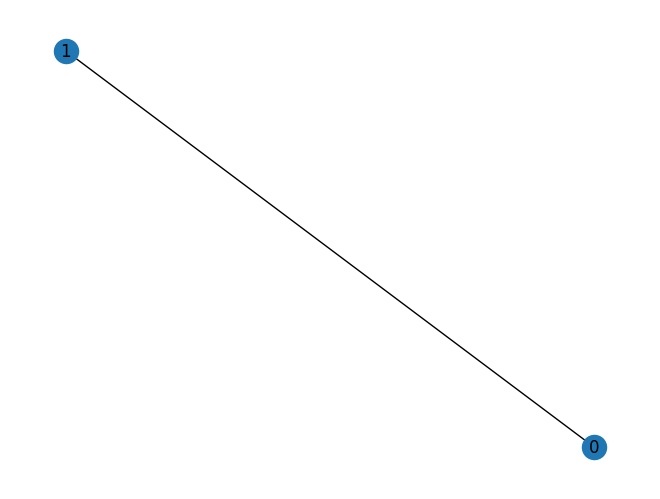

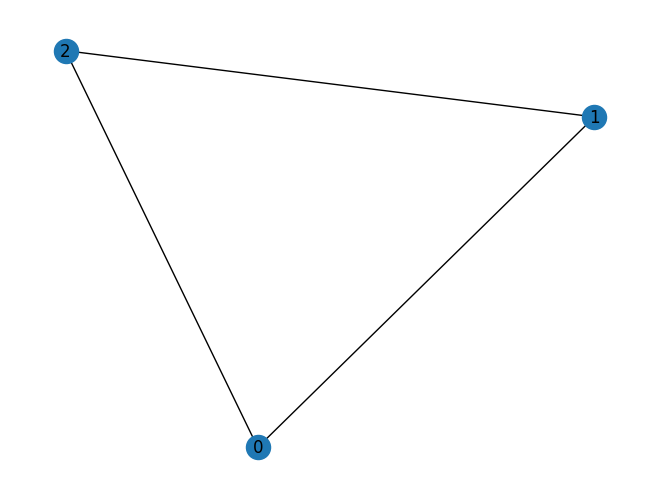

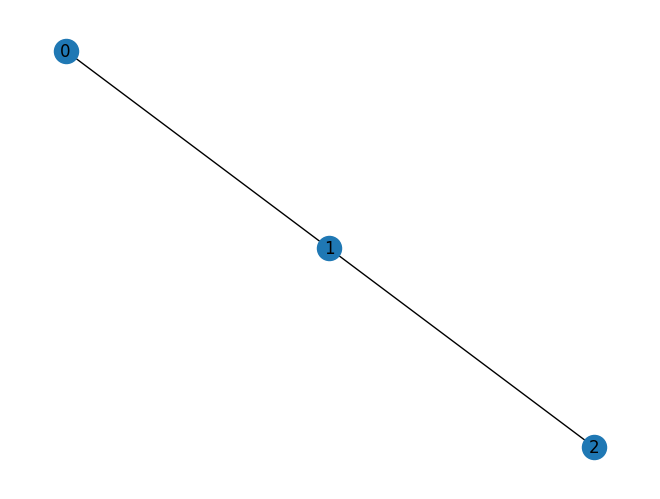

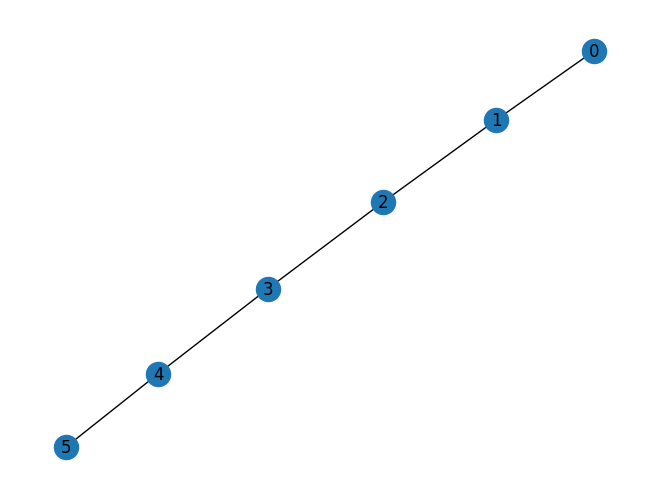

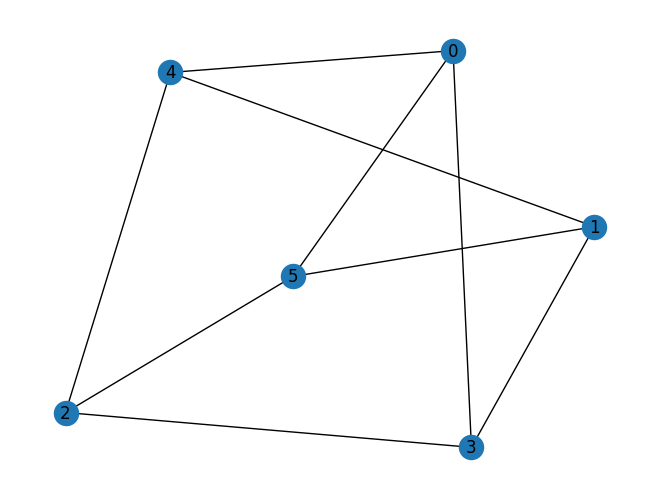

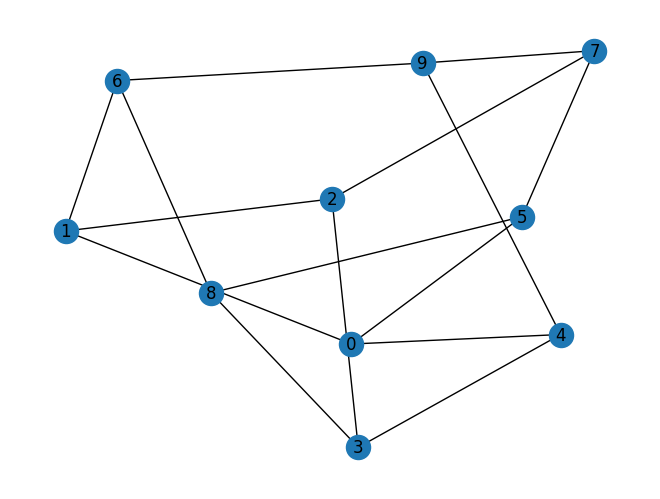

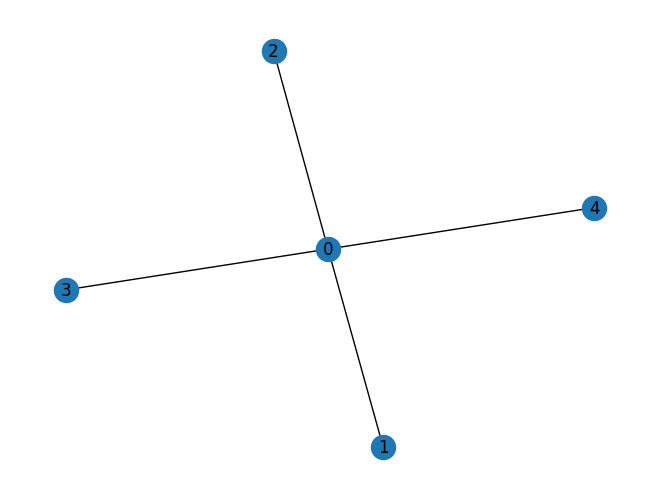

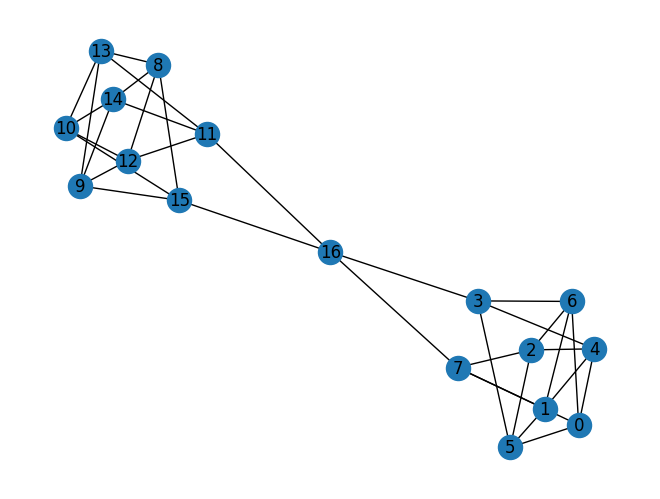

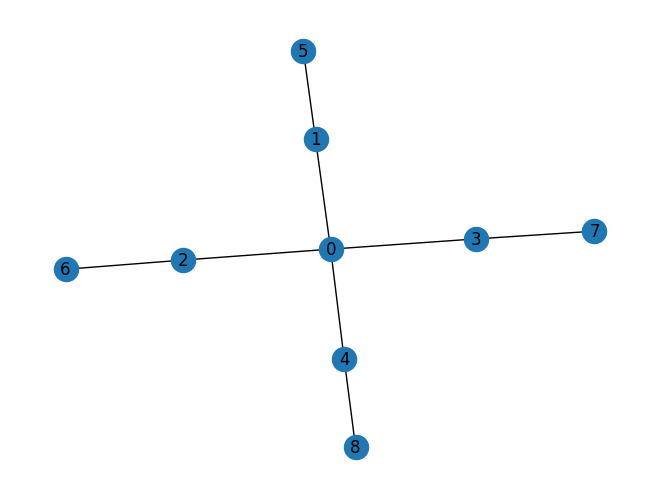

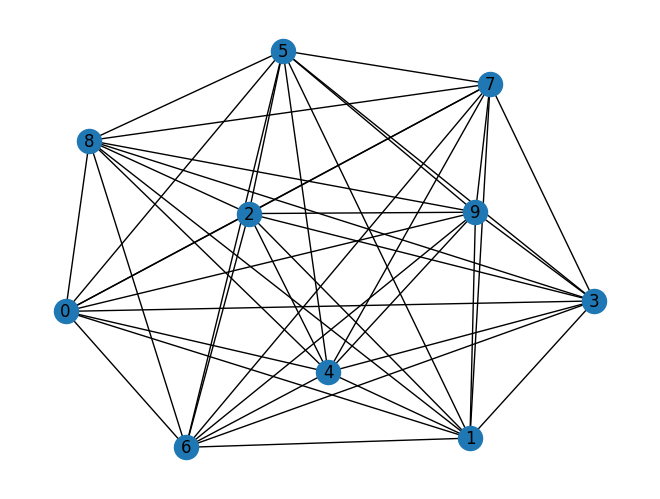

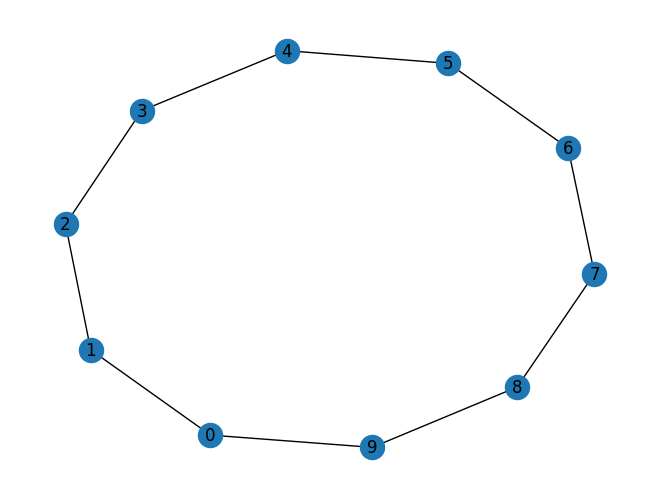

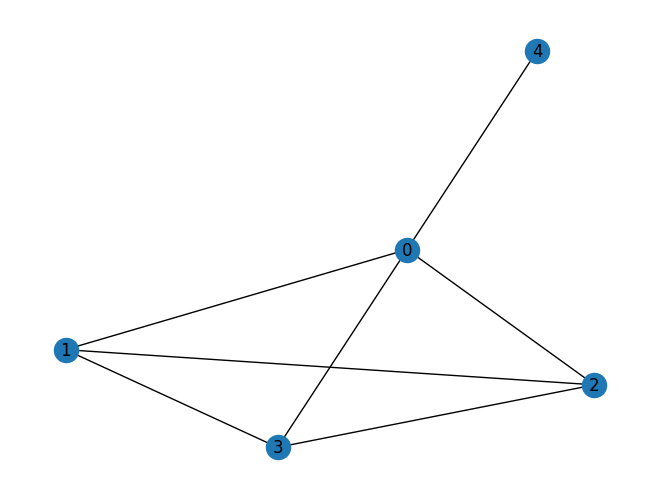

In [23]:
for graph in optimist.graphs:
    nx.draw(graph, with_labels=True)
    plt.show()

In [24]:
optimist.write_on_the_wall("independence_number")

Conjecture 0. If G is a connected and regular graph, then independence_number <= 5/6 * min_maximal_matching_number + 2/3 * domination_number - 1/2
With equality on 4 graphs.


Conjecture 0. If G is a connected graph, then independence_number >= 4/3 * domination_number - 1/3
With equality on 5 graphs.

Conjecture 1. If G is a connected and bipartite graph, then independence_number >= 2/3 * min_maximal_matching_number + 2/3 * domination_number - 1/3
With equality on 4 graphs.

Conjecture 2. If G is a tree, then independence_number >= 1/4 * order + 3/4 * maximum_degree - 1/4
With equality on 4 graphs.

Conjecture 3. If G is a tree, then independence_number >= 1/3 * min_maximal_matching_number + maximum_degree - 1/3
With equality on 4 graphs.

Conjecture 4. If G is a tree, then independence_number >= 1/3 * matching_number + maximum_degree - 1/3
With equality on 4 graphs.

Conjecture 5. If G is a connected and regular graph, then independence_number >= 1/2 * order -1/2 * minimum_degree + 1/